1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. Сделать обзорный анализ выбранного датасета
3. Обучить любой классификатор (какой вам нравится)
4.  разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для 5 случайных объектов из тестового набора

In [1]:
import pandas as pd
import numpy as np
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'target']

In [3]:
df = pd.read_csv('dataset/adult.data', names=columns)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
df['target'].replace({' <=50K':0, ' >50K': 1}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [6]:
df['target'].value_counts()

0    24720
1     7841
Name: target, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], random_state=42)

In [8]:
cat_cols = list(df.select_dtypes(exclude='number').columns)
num_cols = list(df.select_dtypes(include='number').columns)
num_cols.remove('target')

In [9]:
cb_cls = CatBoostClassifier()

In [10]:
cb_cls.fit(X_train, y_train, cat_features=cat_cols, verbose=False)

In [11]:
preds = cb_cls.predict_proba(X_test)[:,1]

In [12]:
metrics = pd.DataFrame([['F-Score'], ['Precision'], ['Recall'], ['AUC']] , columns=['Metric'])

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [14]:
fscore = (2 * precision * recall) / (precision + recall)

In [15]:
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
roc_auc = roc_auc_score(y_test, preds)
metrics['CatBoost'] = [fscore[ix], precision[ix], recall[ix], roc_auc]
metrics

Best Threshold=0.35061523984525544, F-Score=0.736, Precision=0.688, Recall=0.791


,Metric,CatBoost
0,F-Score,0.736004
1,Precision,0.687866
2,Recall,0.791386
3,AUC,0.930397


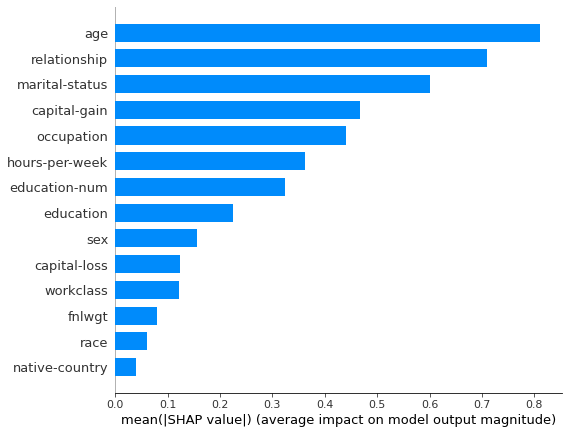

In [16]:
explainer = shap.TreeExplainer(cb_cls)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar")

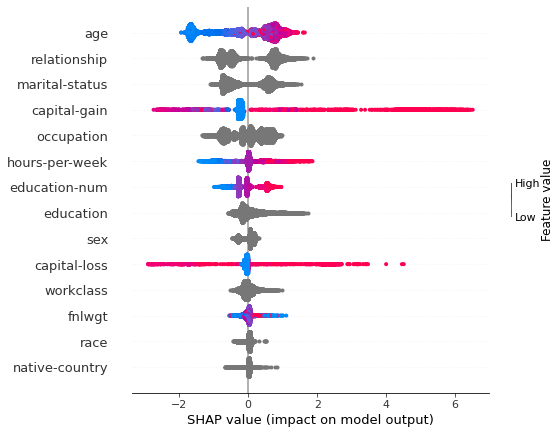

In [17]:
shap.summary_plot(shap_values, X_train)

In [18]:
idx = 1
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

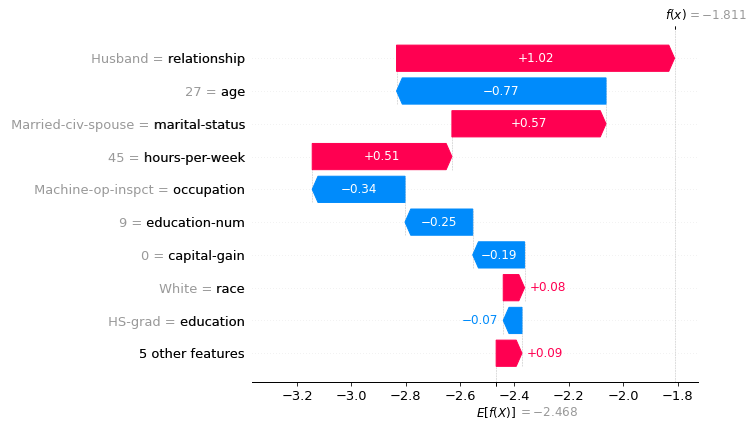

In [19]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [20]:
idx = 10
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

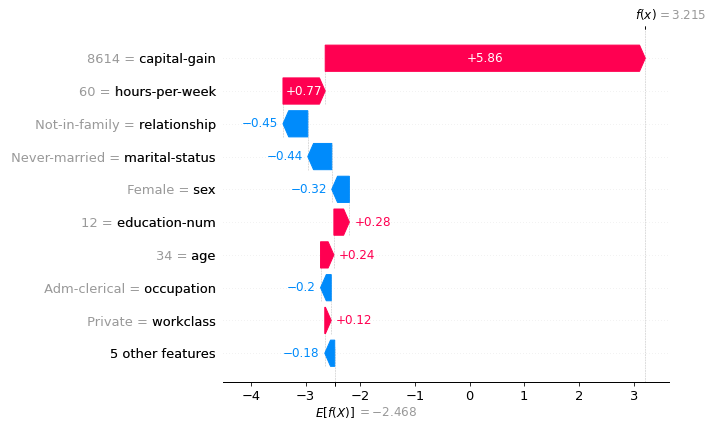

In [21]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [22]:
idx = 20
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

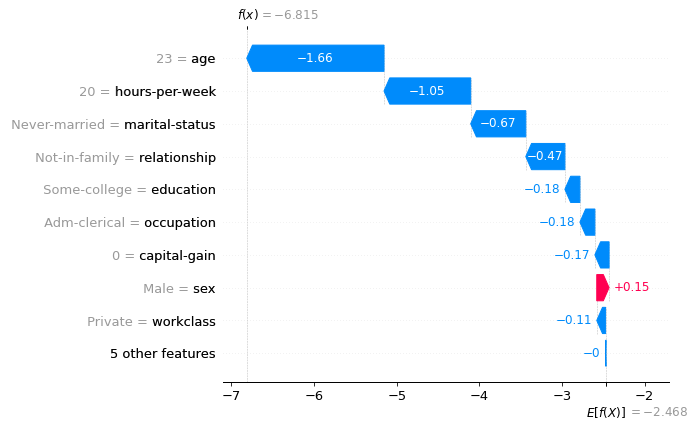

In [23]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [24]:
idx = 100
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

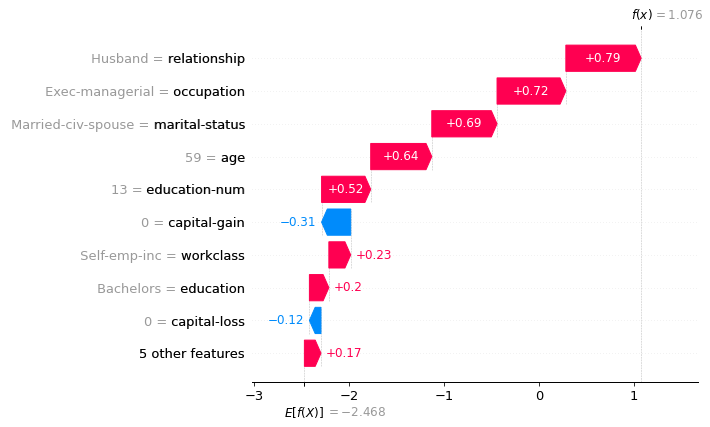

In [25]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [26]:
idx = 1000
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

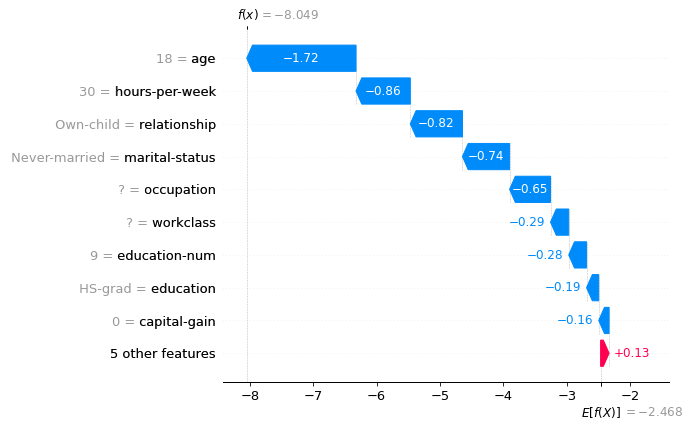

In [27]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])